# Lesson 1 and 2 Notes
- Intro to RFs, how to pre-process, hyperparamters, general fiddling around 

### Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
import os
sys.path.insert(0, "/Users/JI/Documents/Github/fastai/old/")
# print(sys.path)
import fastai
print(sys.modules['fastai'])

<module 'fastai' from '/Users/JI/Documents/Github/fastai/old/fastai/__init__.py'>


In [3]:
from fastai.structured import add_datepart,train_cats,proc_df,fix_missing,numericalize,set_rf_samples,draw_tree
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics


In [4]:
PATH = "./data/bulldozers/"
# !ls {PATH}

### Load Dataset

In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

### Look at the Data

#### Display all cols in a df

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
# functions to look inside data
df_raw.head()
df_raw.dtypes
df_raw.columns
df_summ = DataFrameSummary(df_raw)
display_all(df_summ.summary())

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
count,401125,401125,401125,401125,401125,380989,401125,142765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.91971e+06,31099.7,1.2179e+06,6889.7,134.666,6.55604,1899.16,3457.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,909021,23036.9,440992,6221.78,8.96224,16.9768,291.797,27590.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.13925e+06,4750,0,28,121,0,1000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.41837e+06,14500,1.0887e+06,3259,132,1,1985,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.63942e+06,24000,1.27949e+06,4604,132,2,1995,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.24271e+06,40000,1.46807e+06,8724,136,4,2000,3025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,6.33334e+06,142000,2.48633e+06,37198,172,99,2013,2.4833e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
counts,401125,401125,401125,401125,401125,380989,401125,142765,69639,401125,401125,401125,263934,56908,71919,190350,401125,401125,401125,401125,104361,400800,192077,79134,148606,79134,183230,79134,25219,25219,25219,25219,320570,25219,104137,25230,25219,94718,213952,43458,43362,43362,99153,99872,99218,99288,99218,99153,78672,79833,79834,69411,69369
uniques,401125,899,341027,5218,5,30,72,15152,3,3919,4999,1950,175,122,139,6,74,53,6,6,4,6,2,4,3,2,8,2,2,6,3,2,12,2,4,2,3,17,3,2,2,3,2,19,29,3,3,3,2,10,7,4,5


### Pre-Processing Steps
Need to make cols numeric
1. change dates to numerics (add_datepart)
2. change all string names to categorical variables (train_cats). To apply the same categorical mappings to test set, use (apply_cats). Make sure the categorical mappings make sense, i.e. Low, Med, High instead of High, Low, Med etc.
3. Take care of missing/null values (proc_df does all of below)
    - if numeric, add new col(_na) with 1 or 0, and fill na with median value (fix_missing)
    - pandas auto sets null categorical values to -1, so add 1 to all codes using (numericalize)

#### Transform output
- the project uses RMSLE (root mean squared log error), therefore transform the output variable SalePrice by taking the log

In [8]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [9]:
df_raw.SalePrice

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
401120     9.259131
401121     9.305651
401122     9.350102
401123     9.104980
401124     8.955448
Name: SalePrice, Length: 401125, dtype: float64

#### Change dates to numerics and add interesting date info

In [10]:
add_datepart(df_raw,'saledate')

#### Change strings to categoricals

In [11]:
train_cats(df_raw)

In [12]:
display(df_raw.UsageBand.cat.categories)
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
display(df_raw.UsageBand.cat.categories)

Index(['High', 'Low', 'Medium'], dtype='object')

Index(['High', 'Medium', 'Low'], dtype='object')

In [13]:
# or replace with numbers
df_raw.UsageBand = df_raw.UsageBand.cat.codes

#### Save Pre-Processed data in feather format

In [14]:
os.makedirs('tmp',exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

#### Take care of null values

In [15]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

In [16]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [17]:
df, y, nas = proc_df(df_raw, 'SalePrice')
df

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,2,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,0,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,0,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,1,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,1840702,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401121,6333337,1830472,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401122,6333338,1887659,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401123,6333341,1903570,21435,149,2.0,2005,0.0,-1,483,159,...,298,False,False,False,False,False,False,1319500800,False,True


### Random Forests
- A tree consists of a sequence of binary decisions/splits
- How do you find the most simple basic split (which variable, which split point)?
    - for every feature and for every split within that feature, we find the weighted avg of the mse, which one had the best mse and we picked that
    - split when you hit a limit, or when leaf nodes have only one decision left
- How can you make a decision tree better?
    - **FORESTS!** RFs are simply a way of *Bagging* trees
- What is Bagging?
    - construct multiple uncorelated models whose errors are close to random
- What are some RF hyperparameters?
    - num_estimators(trees) - as many as you have time to fit, give you good R^2 (mostly testing using 20,30 - finally using 1k or so)
    - min_samples_leaf - min # of samples
    - 

#### Basic Model

In [18]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df,y)
%time m.score(df,y)

/Users/JI/miniconda2/envs/fastai_ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 3.38 s, sys: 482 ms, total: 3.87 s
Wall time: 4.66 s


0.9830441925135424

#### Creating a validation set

In [19]:
# split raw df into train and val sets, val set contains most recent values
def split_vals(a,n):
    return a[:n].copy(),a[n:].copy()

n_valid = 12000 # same as Kaggle's test set
n_train = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw,n_train)
X_train, X_valid = split_vals(df,n_train)
y_train, y_valid = split_vals(y,n_train)

X_train.shape, y_train.shape, X_valid.shape
# a = np.array([1,2,3,4,5,6,7,8,9]) # figuring out what split_vals does
# split_vals(a,3)

((389125, 66), (389125,), (12000, 66))

#### Re-training with validation set

In [20]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

In [21]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train,y_train)
print_score(m)

/Users/JI/miniconda2/envs/fastai_ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 46s, sys: 1.73 s, total: 1min 47s
Wall time: 54.2 s
[0.09055126352252664, 0.24971549372269145, 0.9828634317298817, 0.8886375050116944]


#### Understanding R<sup>2</sup>
- Formula = 1 - u/v
- u = ((y_true - y_pred) ** 2).sum()
- v = (y_true - y_true.mean()) ** 2).sum()
- Range of R<sup>2</sup>
    - 0: exactly as effective as predicting the mean
    - 1: your model is perfect
    - negative: your model is worse than predicting the mean

#### Speeding things up
If something takes longer than 10s to run, it's to slow to be interactive. Ideally, you want to create a model and tune hyperparameters quickly, then run on entire dataset when you head home
- Run your models on subsamples of the data, will give you most of the insights you can get, rather than training on all of huge dataset
- Keep validation set the same

In [22]:
df_trn, y_trn, nas = proc_df(df_raw,'SalePrice',subset=30000,na_dict=nas)
X_train, _ = split_vals(df_trn,20000)
y_train, _ = split_vals(y_trn,20000)

In [23]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train,y_train)
print_score(m)

/Users/JI/miniconda2/envs/fastai_ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 4.09 s, sys: 94.8 ms, total: 4.18 s
Wall time: 2.17 s
[0.11189722858244212, 0.37754777983609494, 0.9731297556625634, 0.7454390309909147]


### From a Tree to a Forest

In [24]:
m = RandomForestRegressor(n_estimators=1,max_depth=3,bootstrap=False,n_jobs=-1)
m.fit(X_train,y_train)
print_score(m)

[0.5277555678016201, 0.5812124337376615, 0.4022788784804576, 0.3967216125074502]


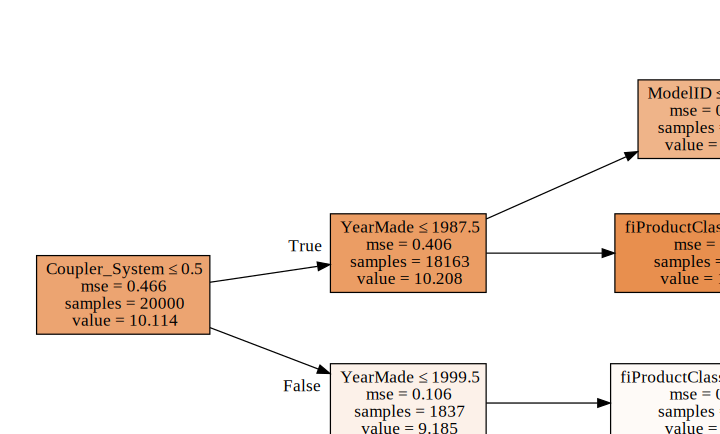

In [25]:
draw_tree(m.estimators_[0],df_trn,precision=3)

In [26]:
m = RandomForestRegressor(n_estimators=1,bootstrap=False,n_jobs=-1)
m.fit(X_train,y_train)
print_score(m)

[6.879800455918813e-17, 0.521811415024116, 1.0, 0.5137326337068726]


#### Bagging
- **Ensembling**: multiple models (weak learners) combined to form final prediction
- create many different models in parallel that are uncorrelated with each other and average the results. Because errors are not correlated with each other, this works 

In [27]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train,y_train)
print_score(m)

/Users/JI/miniconda2/envs/fastai_ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11147220552610917, 0.39185366817496936, 0.9733334923257594, 0.7257820958702438]


In [28]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds.shape,preds[:,0], np.mean(preds[:,0]), y_valid[0]

((10, 12000),
 array([9.51044, 9.4727 , 9.10498, 9.68034, 9.87817, 9.04782, 9.15905, 9.71112, 9.04782, 9.10498]),
 9.371742868171477,
 9.104979856318357)

In [29]:
preds[:,1]

array([ 9.95228,  9.51044,  9.54681,  9.51044,  9.95228,  9.39266,  9.39266, 10.12663,  9.51044,  9.39266])

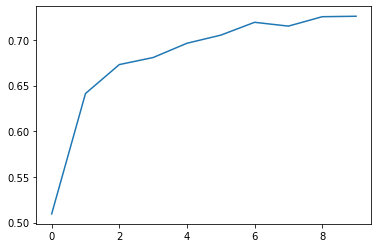

In [30]:
values = [metrics.r2_score(y_valid,np.mean(preds[:i+1],axis=0)) for i in range(10)]
plt.plot(values)
# gets better with more estimators

In [31]:
# adding more trees doesn't yield significant benefits after a while
for i in [20,40,80]:
    m = RandomForestRegressor(n_estimators=i,n_jobs=-1)
    m.fit(X_train,y_train)
    print_score(m)

[0.10210987259079504, 0.3693337079916632, 0.9776247228357825, 0.7563951859538223]
[0.09644836438868576, 0.3716241633374973, 0.9800371433003076, 0.7533643437975398]
[0.09392476342896544, 0.37156455884610257, 0.9810681447699681, 0.753443452829675]


### Out of Bag
When your dataset is small, so you don't have enough to create a validation set - you can take the unused samples from each tree and train a sort of validation set from that.
- don't use oob_score when you use set_rf_samples (below) because you'll take the rest of the samples (in a large dataset this defeats the purpose of sampling) and you use set_rf_samples to subsample a huge dataset. At that point better to just create a validation set
-oob score is on avg less good than validation set score b/c it uses a subset of the trees. The validation set score is based on the trained models all the trees in the ensemble

### Subsampling
Instead of just using a subset like before, and running all analysis on that subset - use the entire dataset but sample differently from the entire set. Rather thank limit total amount of data that our model can access, instead limit it to a different random subset per tree.

In [35]:
# set training set to be the entire dataset again, instead of 30k samples from above
df_train, y_train, _= proc_df(df_raw,'SalePrice')
X_train, X_valid = split_vals(df_train,n_train)
y_train, y_valid = split_vals(y_train,n_train)
X_train.shape,X_valid.shape

((389125, 66), (12000, 66))

In [36]:
# now the RF will bootstrap a subset of 20k rows, not ~400k rows
set_rf_samples(20000)
# reset_rf_samples()

In [38]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train,y_train)
print_score(m)

/Users/JI/miniconda2/envs/fastai_ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 9.67 s, sys: 445 ms, total: 10.1 s
Wall time: 5.56 s
[0.24095524034235186, 0.2802500732780849, 0.8786589977464384, 0.8597381884791299, 0.8659817826033842]


In [40]:
# increase estimators/trees
m = RandomForestRegressor(n_estimators=100,n_jobs=-1, oob_score=True)
%time m.fit(X_train,y_train)
print_score(m)

CPU times: user 1min 42s, sys: 2.68 s, total: 1min 45s
Wall time: 55.3 s
[0.22441554786275103, 0.26037913705381915, 0.8947454907827561, 0.8789233654885561, 0.8834285928489057]


### Other hyper-parameters

In [41]:
# vary min leaves in tree (1,3,5,10,25 possible values)
m = RandomForestRegressor(min_samples_leaf=3,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

/Users/JI/miniconda2/envs/fastai_ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.24103440965016054, 0.27437184720409347, 0.8785792479861292, 0.8655604443724038, 0.8688935926782921]


In [42]:
# change max_features, different subset of columns (1,.5,log2,sqrt)
m = RandomForestRegressor(min_samples_leaf=3,max_features=0.5,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

/Users/JI/miniconda2/envs/fastai_ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.24427304105656325, 0.2754651168116147, 0.8752944148875088, 0.8644869267403102, 0.8658557643218491]


In [45]:
df_raw.fiProductClassDesc.cat.categories

Index(['Backhoe Loader - 0.0 to 14.0 Ft Standard Digging Depth',
       'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
       'Backhoe Loader - 15.0 to 16.0 Ft Standard Digging Depth',
       'Backhoe Loader - 16.0 + Ft Standard Digging Depth',
       'Backhoe Loader - Unidentified',
       'Hydraulic Excavator, Track - 0.0 to 2.0 Metric Tons',
       'Hydraulic Excavator, Track - 11.0 to 12.0 Metric Tons',
       'Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons',
       'Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons',
       'Hydraulic Excavator, Track - 150.0 to 300.0 Metric Tons',
       'Hydraulic Excavator, Track - 16.0 to 19.0 Metric Tons',
       'Hydraulic Excavator, Track - 19.0 to 21.0 Metric Tons',
       'Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons',
       'Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons',
       'Hydraulic Excavator, Track - 24.0 to 28.0 Metric Tons',
       'Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons',
 

## Notes

- It's good not knowing about the dataset before hand, will keep you open-minded as to what the data is saying

- Kaggle API: https://github.com/Kaggle/kaggle-api

- you can open a terminal within jupyter

- can run shell commands from jupyter with ! before, eg. **!ls /path** or **!ls {PATH}**

- read_csv low_memory=False reads in more of the file

- look at the evaluation metric to determine how to modify the variables (log loss, etc.)

- RFs are very robust, great place to start

- Scikit learn steps: 
        1. Create Instance of model you want
        2. call fit, pass in independent variables, and dependent variable


- ? docs, ?? source code

- pandas has a Category data type but doesn't change anything into it by default, use train_cats(df) to do so. Stores a mapping from integers to the strings

- RFs are trivially parallelizable (it will split up data across CPUs and linearly scale) n_jobs=-1

- the fastai library in this directory is a symlink (file that points to another file) pointing to the original fastai folder ../../old/fastai
ln -s ../../old/fastai

- R^2 is useful, ratio of how good your model is (root mean squared error) versus how good the naive mean model is (root squared error)

- creating validation set is most important thing to do in a ML model. Test set should never be touched until you are done done with modeling.

- when dealing with time series data, you want your test set to be of a different time (future) than your training set. So set your validation set to be different as well, not randomized.

- an effective ML model is accurate for the training set and also generalizes well

### Figuring out what add_datepart does

In [ ]:
test_df = df_raw[['saledate']]

In [ ]:
test_df.columns = ['testing']
test_df

In [ ]:
add_datepart(test_df,'testing')


In [ ]:
test_df

In [ ]:
add_datepart(df_raw,'saledate')

In [ ]:
df_raw